## Data Loading

We will first load the data locally and then upload to S3.

In [1]:
import sys
sys.path.append('../source')

from dataset.ENindoor67 import ENindoor67

In [2]:
# Instantiate the dataset from local directory
dataset = ENindoor67(root_dir='../data/mit_indoor_67/raw/Images')

../source/dataset/ENindoor67.py:313: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  for k, v in dict(pd.Series(self['Category'].unique())).items()}


The categories and labels of the dataset has been loaded in `ENindoor67.dataframe` upon instantitation.

In [3]:
dataset.dataframe.head()

Path    Category  Class
0  ../data/mit_indoor_67/raw/Images/inside_bus/in...  inside_bus      0
1  ../data/mit_indoor_67/raw/Images/inside_bus/in...  inside_bus      0
2  ../data/mit_indoor_67/raw/Images/inside_bus/in...  inside_bus      0
3  ../data/mit_indoor_67/raw/Images/inside_bus/in...  inside_bus      0
4  ../data/mit_indoor_67/raw/Images/inside_bus/in...  inside_bus      0

### Upload data to S3
Now that the data is loaded properly at local directories. Let's upload the data to S3 - this should take a few minutes.

In [4]:
import os
import boto3
from sagemaker.session import Session
from utils.s3 import s3_upload
root_dir = '../data/mit_indoor_67/raw/Images'
session = Session()
bucket = session.default_bucket()
prefix = 'mit_indoor_67/raw'

s3_upload(root_dir=root_dir,
          session=session,
          bucket=bucket,
          prefix=prefix)

Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/inside_bus
Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/bar
Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/nursery
Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/restaurant
Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/hospitalroom
Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/grocerystore
Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/classroom
Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/restaurant_kitchen
Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/shoeshop
Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/trainstation
Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/elevator
Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/bathroom
Uploaded: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/movietheater


's3://sagemaker-us-east-2-194071253362/mit_indoor_67/raw/bedroom'

In [5]:
# Update dataset path
dataset.dataframe['Path'] = dataset.dataframe['Path'].apply(lambda path: '/'.join([prefix] + path.split('/')[-2:]))
dataset.dataframe.head()

Path    Category  Class
0  mit_indoor_67/raw/inside_bus/inside_bus_001.jpg  inside_bus      0
1  mit_indoor_67/raw/inside_bus/inside_bus_079.jpg  inside_bus      0
2  mit_indoor_67/raw/inside_bus/inside_bus_038.jpg  inside_bus      0
3  mit_indoor_67/raw/inside_bus/inside_bus_086.jpg  inside_bus      0
4  mit_indoor_67/raw/inside_bus/inside_bus_021.jpg  inside_bus      0

In [6]:
dataset.dataframe.to_csv('../data/mit_indoor_67.csv', index=False, encoding='utf-8')

The dataset image has been downloaded and `s3_upload` to S3. We will hence load data from .csv and respective s3 locations. 

In [7]:
# Read Dataset from S3
s3_bucket = bucket=boto3.resource('s3').Bucket(bucket)
dataset = ENindoor67(data_file='../data/mit_indoor_67.csv', s3_bucket=s3_bucket)

---
## Data Preparation

The dataset is customized from `Pytorch.utils.data.Dataset`. The dataset is automatically cleaned and labelled in the constructor and is configured when calling `__getitem__` (see source code in `ENindoor67.py`). To configure the dataset, the following methods are implemented:


the data set can be called in two `mode`:


`toraw` : in "raw" mode, a dictionary with `PIL.Image` will be returned

`totensor` : in "tensor" mode, the transformed, normalized tensor array of the image and its class label will be returned

In addition, the the data can be called with the following configurations:

`original` : images will be called as their original size, color, and texture

`transformed` : images will be called as transformed state

`augmented` : the train set will be augmented


Initially the data is also loaded from a local directory; to facilitate Pipe mode on AWS, the `upload` method is also defined in this custom dataset class. 

---
## Data Exploration and Visualization

To succinctly show what is done in each step, the codes for exploration and visualization have been wrapped in the `ENindoor67` class.

### Show original images
Let's have a look at the original images:

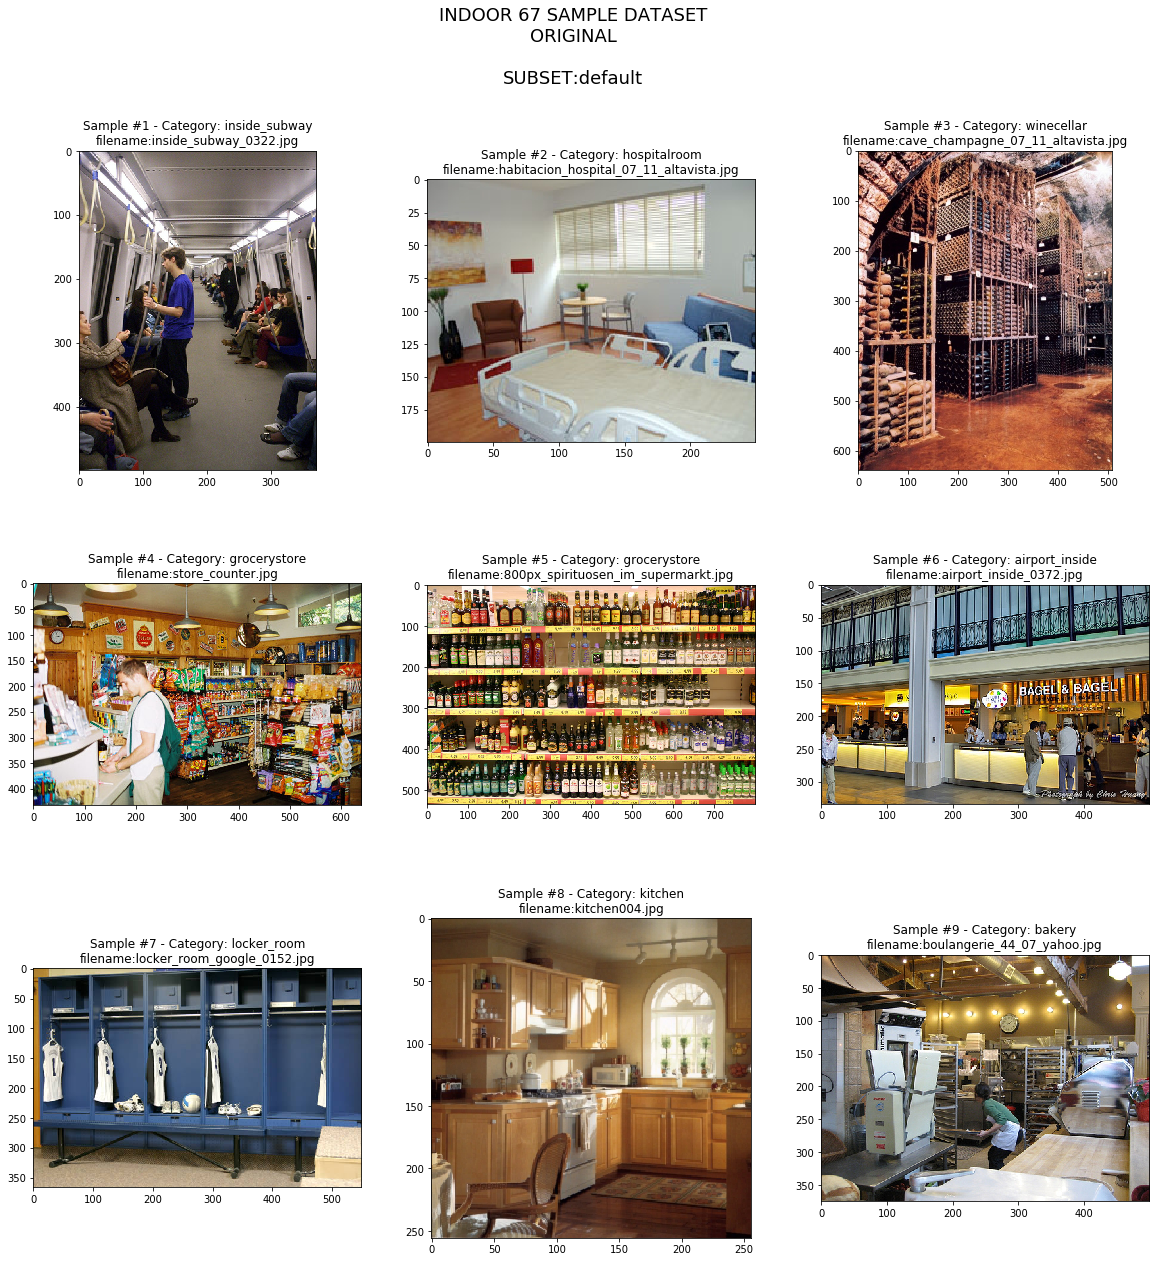

In [8]:
dataset.original()
dataset.show_sample()

While the images are of different sizes, EfficientNet requires images to be resized to certain resolutions. Hence, the images shall be resized first.

Again, these methods have been written and wrapped in the custom dataset class.

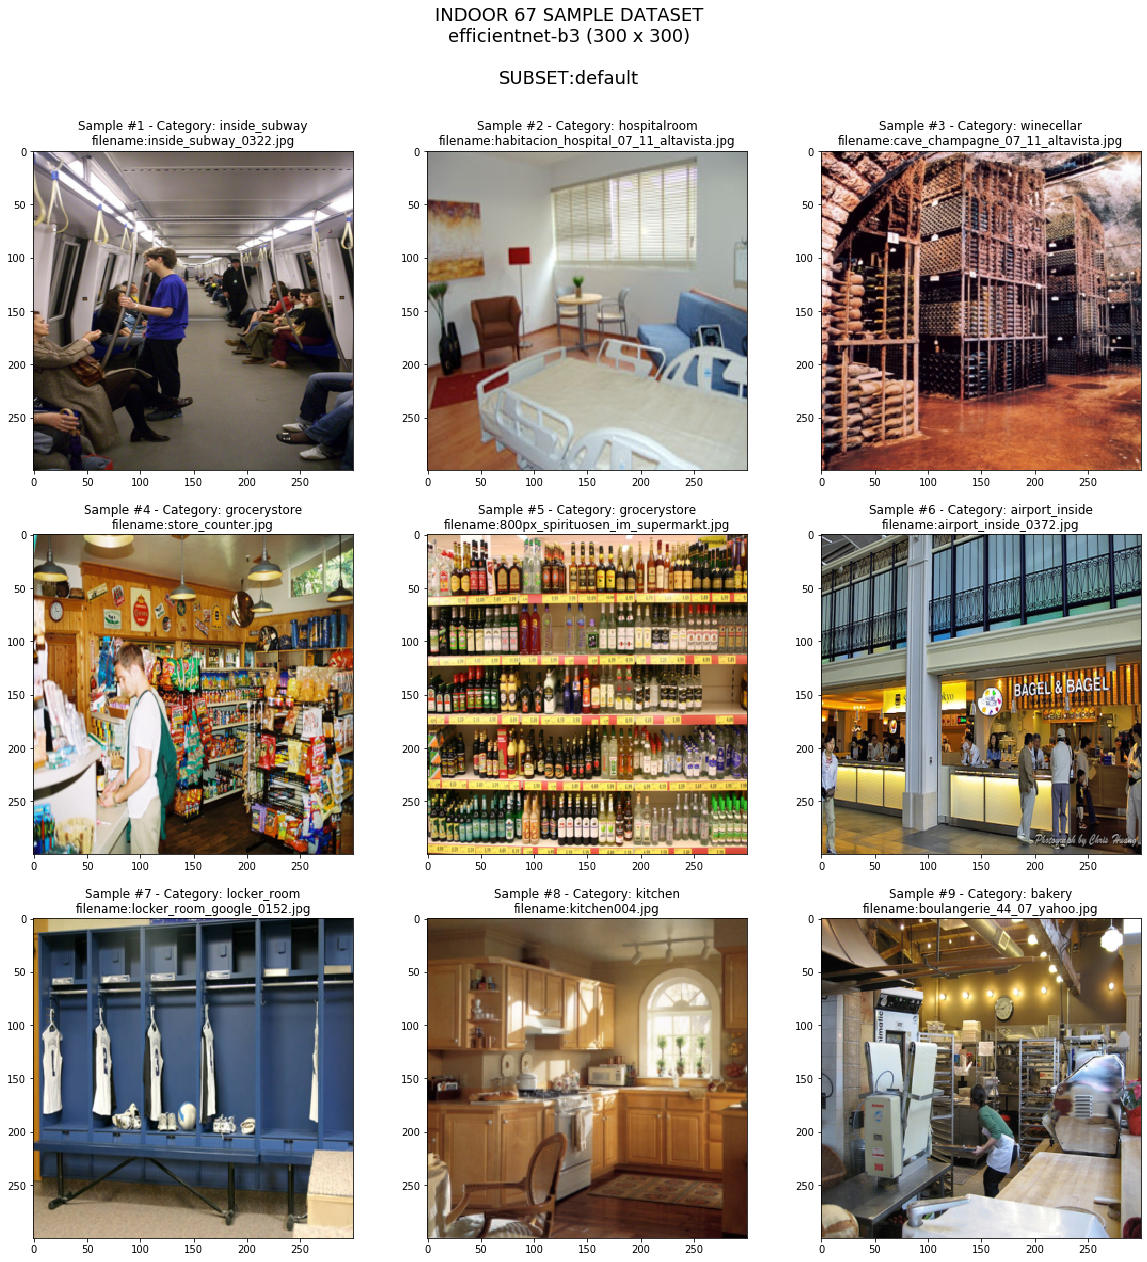

In [9]:
dataset.switchNet('efficientnet-b3')
dataset.transformed()
dataset.show_sample()

Let's have a look at the class distributions

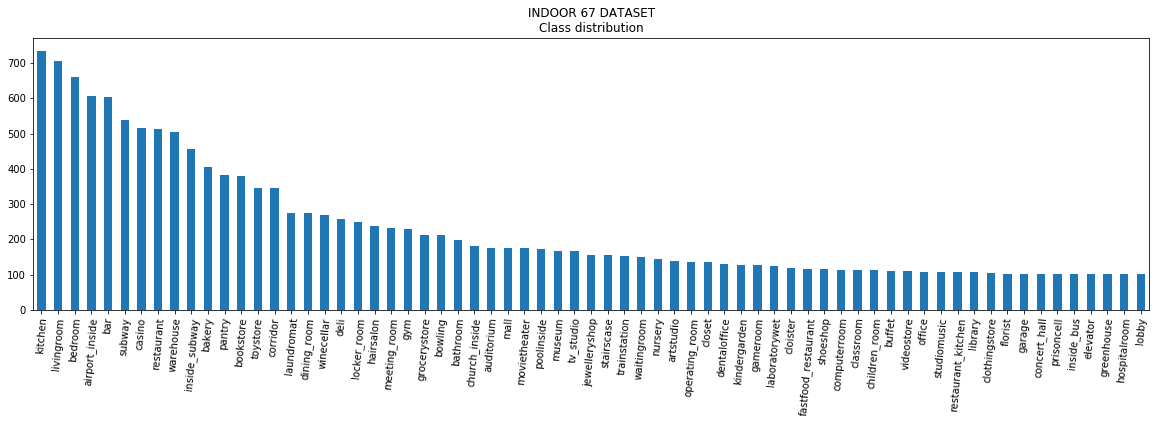

In [10]:
dataset.plot_distributions()

The classes are rather unevenly distributed, but seem to follow the how frequent a scene might be in most people's daily life.

One way to avoid overfitting in image classification is to apply data augmentation. However, only the `train` set will be `augmented` for training, while the `val` and `test` sets are left unaugmented. To do so, the dataset needs to be split first of all.

The `sample` method automatically calls its own `train_val_test_split` method which is modified from `sklearn.model_selection.train_test_split` and uses Pytorch sampling methods: either `WeightedRandomSampler` or `SubsetRandomSampler` (default: `WeightedRandomSampler`, defined as `weighted`; to use the later, defined as `subsetrandom`)

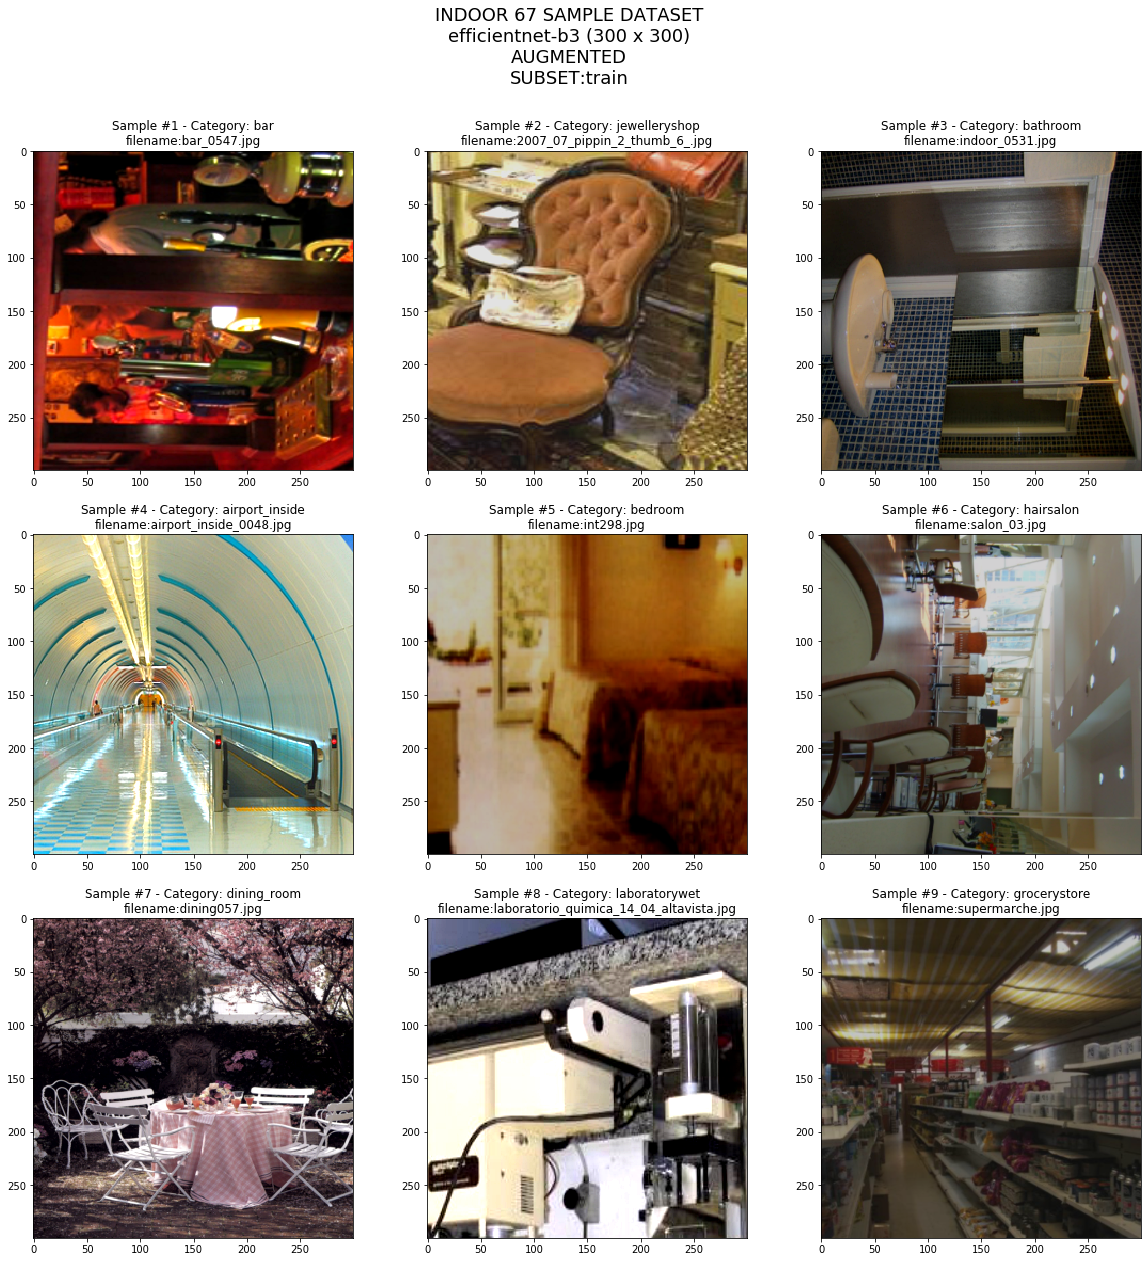

In [11]:
dataset.sample(method='subsetrandom', train_size=0.8, val_size=0.2)
dataset.augmented()
dataset.show_sample(subset='train')  # show `train` set

It looks like the train data are well augmented by various techniques.


Let's have a look at the data distribution:

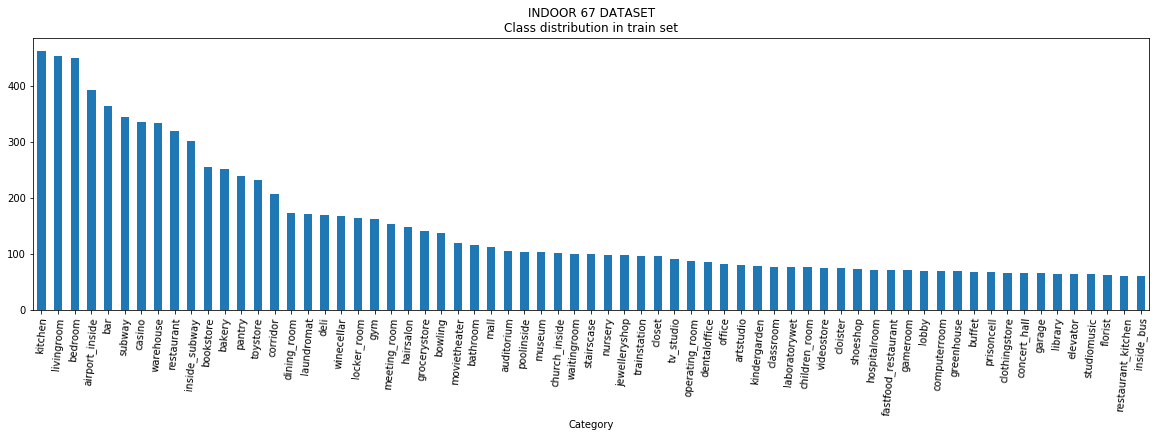

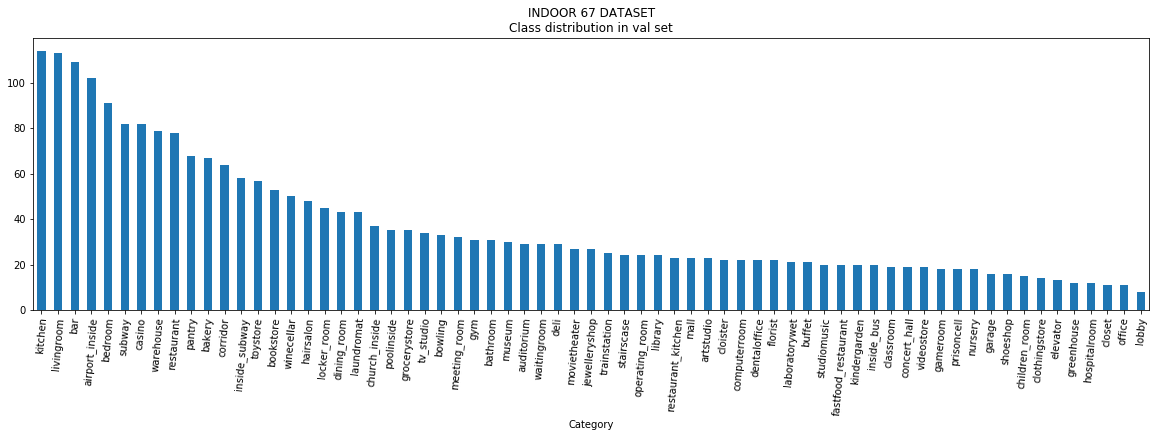

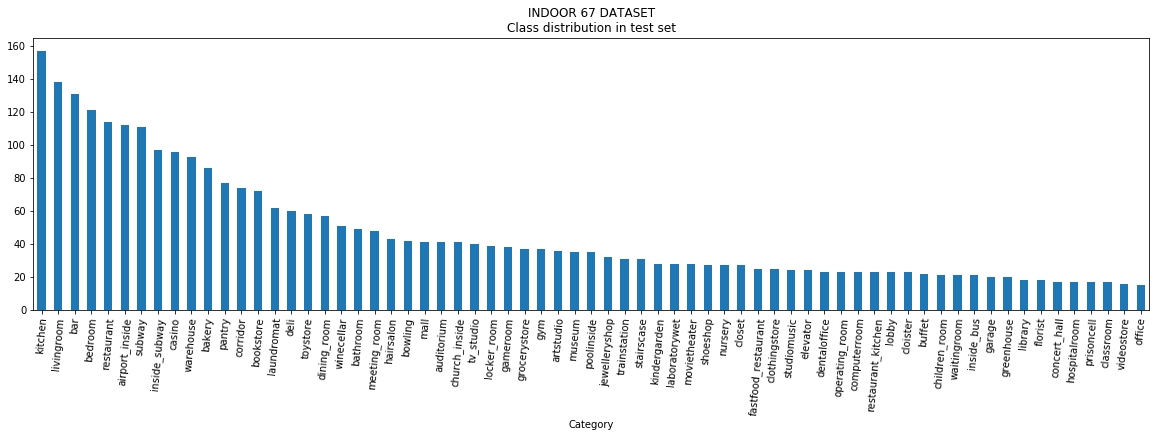

In [12]:
dataset.plot_distributions()

The distributions of the categories are rather unevenly distributed and slighlty not proportional across sets. Let's see if there is any difference if we use a `stratified` splitting method.

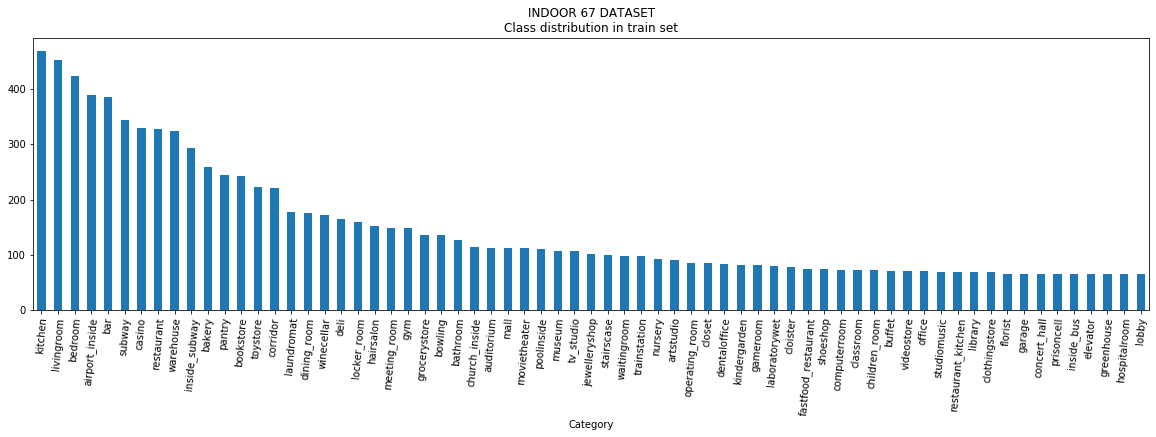

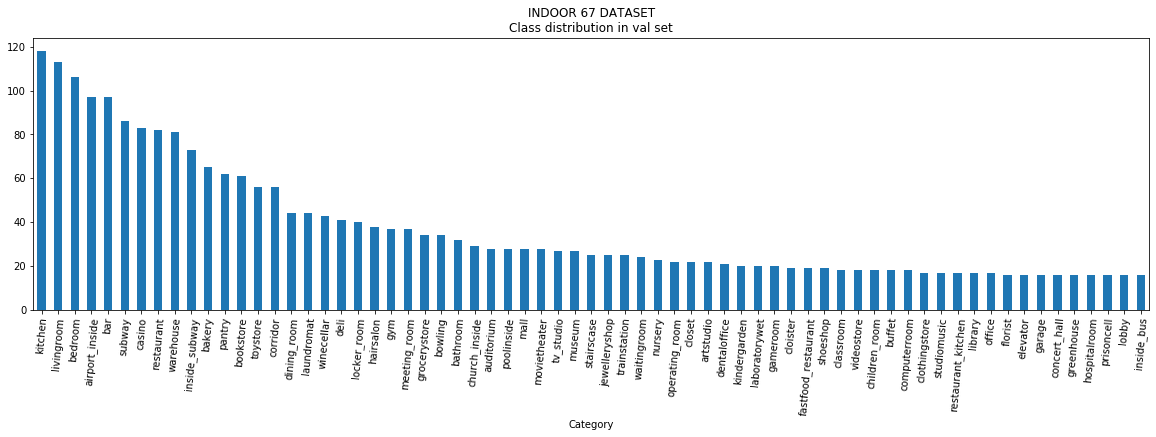

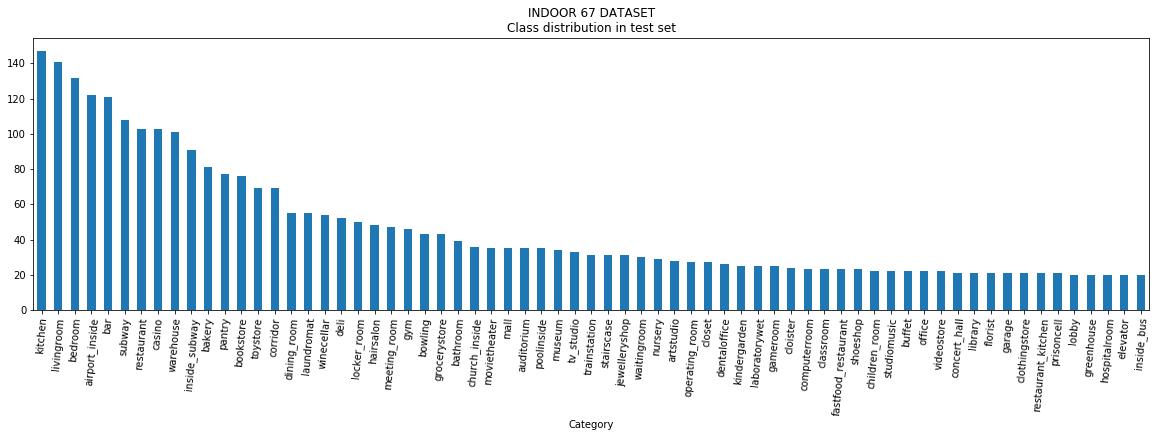

In [13]:
dataset = ENindoor67(data_file='../data/mit_indoor_67.csv', s3_bucket=s3_bucket)  # reinstantiate the dataset
dataset.sample(method='subsetrandom', train_size=0.8, val_size=0.2, stratify=True)
dataset.plot_distributions()

Now, the datasets seem to be more proprotional to each other.

We shall now go to [preprocess our data](ENindoor67-Preprocessing.ipynb).

In [14]:
# Remove local directory
!rm -rf $root_dir/*
!rmdir $root_dir